## Fitting Spline kernel on CAMELS 

In [43]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [44]:
# import gdown
# gdown.download('https://drive.google.com/uc?id=1oy1cO8o2B8g3-PYxf6bCo3wVcZEjRSYf', quiet=True)
# !unzip CV_1.zip

In [45]:
%pylab inline
from tqdm import tqdm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [46]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

In [47]:
#import camels_library as cl
import readgadget

init_cond = 'CV_1/ICs/ics'

header   = readgadget.header(init_cond)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(init_cond, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(init_cond, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(init_cond, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(2,2,2,128,128,128,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(2,2,2,128,128,128,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i = (pos_i/BoxSize*64).reshape([256,256,256,3])[::2,::2,::2,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::2,::2,::2,:].reshape([-1,3])
a_i   = 1./(1+redshift)

In [48]:
scales = []
poss = []
vels = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='CV_1/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)     #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids] / 1e3        #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]              #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [03:51<00:00,  6.80s/it]


In [49]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk


from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum
#import numpyro 
rng_seq = hk.PRNGSequence(1)

In [50]:
# Run the reference simulation without correction at the same steps
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

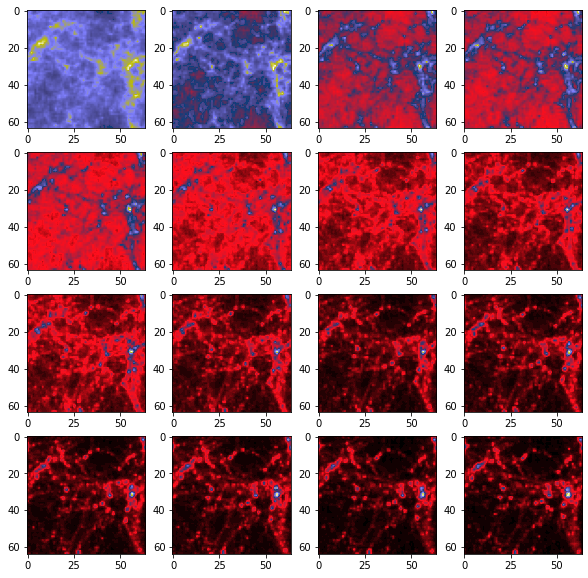

In [51]:
# High res simulation
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

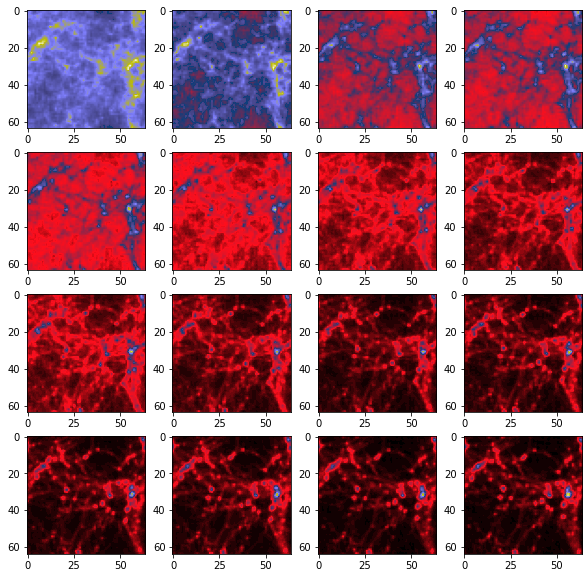

In [52]:
# JaxPM without correction
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [53]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

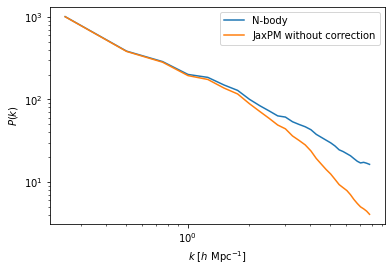

In [13]:
loglog(k,pk_ref, label='N-body')
loglog(k,pk_i, label='JaxPM without correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

### Fitting neural network

In [58]:
from  Net3d import*
class ComplexSpectral(hk.Module):

    def __init__(self,width,modes1=8,modes2=8,modes3=8, padding=3,name="PaperNetwork"):
        
        super().__init__(name=name)
        self.modes1= modes1
        self.modes2= modes2
        self.modes3= modes3
        self.width = width
        self.padding=6
        self.conv0 = SpectralConv3(1, self.width, self.modes1, self.modes2, self.modes3, name='l0')
        self.conv1 = SpectralConv3(self.width, 1, self.modes1, self.modes2, self.modes3, name='l1')
        # self.conv2 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l2')
        # self.conv3 = SpectralConv3(self.width, self.width, self.modes1, self.modes2, self.modes3, name='l3')

        
    def __call__(self,x):

        
        #print("Start",x.shape)
        
        dim1,dim2,dim3=x.shape
        #Fourier Space
        print(x.shape)
        x1 = x[jax.numpy.newaxis,jax.numpy.newaxis,...]
        x1 = self.conv0(x1)
        x1 = np.squeeze(x1, axis=0)
        x1=jnp.fft.irfftn(x1,s=(dim1,dim2,dim3+31))
        print(x1.shape)
        x = jax.nn.relu(x1)
        print(x.shape)
        #Another Spectral 
        x1 = jnp.fft.rfftn(x,s=(dim1,dim2,dim3+31))
        x1 = x1[jax.numpy.newaxis,...]
        x1 = self.conv1(x1)
        #x1=jnp.fft.irfftn(x1,s=(dim1,dim2,dim3))
        x1 = np.squeeze(x1, axis=0)
        #x = jax.nn.relu(x1)
        print(x1.shape)
        
        return x1



# Instantiate the neural network
#model = hk.without_apply_rng(hk.transform(lambda x : ComplexSpectral(width=20)(x)))
# Instantiate the neural network

model = hk.without_apply_rng(hk.transform(lambda x : SpectralConv3(modes1=32,modes2=32,modes3=32)(x)))

# params = model.init(next(rng_seq),jnp.zeros([1,1,64,64,33]))
#model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter(n_knots=16, latent_size=32)(x,a)))
# params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

In [55]:
def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    # Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # Apply a correction filter
    kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    pot_k = pot_k[jax.numpy.newaxis,jax.numpy.newaxis,...]
    pot_k = pot_k + model.apply(params, pot_k)
    pot_k=jax.numpy.squeeze(pot_k)
    # kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
    # pot_k = pot_k *(1. + model.apply(params, kk, jnp.atleast_1d(a))) 
    # Computes gravitational forces
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [ ]:
# Precomputing a few data stuff
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)
ref_pk = jax.vmap(lambda x: power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), x)),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)[1])(ref_pos)

In [ ]:
@jax.jit
def loss_fn(params):
  res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5) 
  distance = jnp.sum((res[0] - ref_pos)**2, axis=-1)
  w = jnp.where(distance < 100, distance, 0.)

  pk = jax.vmap(lambda x: power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), x)),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)[1])(res[0])

  # Optional lines to include velocity in the loss
  #   vel = jnp.sum((res[1] - ref_vel)**2, axis=-1)
  #   wv = jnp.where(distance < 100, vel, 0.)

  # This loss function contains a penalty on the position of the particles + we want the correct power spectrum
  return jnp.mean(w) + jnp.mean(jnp.sum((pk/ref_pk -1)**2,axis=-1)) #0.001*jnp.mean(wv) + jnp.mean(w)

@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [ ]:
import optax
lr_fun= optax.cosine_decay_schedule(0.1, 1000 , alpha=0.0) #0.1 for 400steps, 0.01
#learning_rate=0.001
optimizer = optax.adam(lr_fun)
opt_state = optimizer.init(params)

In [ ]:
losses = []


In [ ]:
for step in tqdm(range(3000)):
  l, params, opt_state = update(params, opt_state)
  if(step%10==0):
    print("Step: ", step, " Loss: ",l)
  losses.append(l)

  0%|          | 1/3000 [00:02<2:25:47,  2.92s/it]

Step:  0  Loss:  4.617151


  0%|          | 4/3000 [00:14<3:04:19,  3.69s/it]


KeyboardInterrupt: 

In [ ]:
losses[-1]

DeviceArray(nan, dtype=float32)

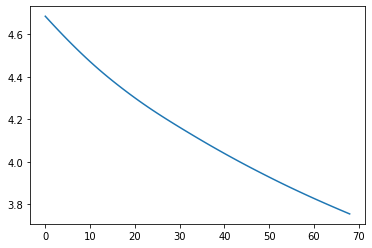

In [ ]:
plot(losses)

Text(0.5, 0, '$k$ [$h \\ \\mathrm{Mpc}^{-1}$]')

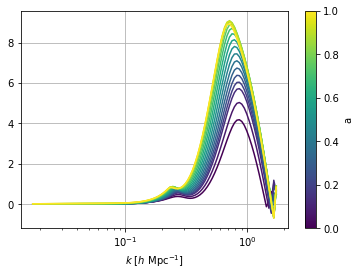

In [ ]:
col = cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   

kvals = jnp.logspace(-2.,0,100)*sqrt(3)

for i, a in enumerate(scales[::2]): 
    semilogx(kvals, model.apply(paramsLoad, kvals , jnp.atleast_1d(a)), color=col[i])

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0., vmax=1))
plt.colorbar(sm, label='a')

#xlim(kvals[0], 1)
#ylim(0,5)
grid()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
#plt.savefig('../figures/filter_k.pdf',bbox_inches='tight')

In [59]:
import pickle
with (open("Spectral_CV0.params", "rb")) as openfile:
    while True:
        try:
            paramsLoad=pickle.load(openfile)
        except EOFError:
            break

In [60]:
res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, paramsLoad, rtol=1e-5, atol=1e-5)

/tmp/ipykernel_4041200/1733304527.py:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = jnp.sqrt(sum((ki/pi)**2 for ki in kvec))
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/ops/scatter.py:114: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


Spectral Initialized


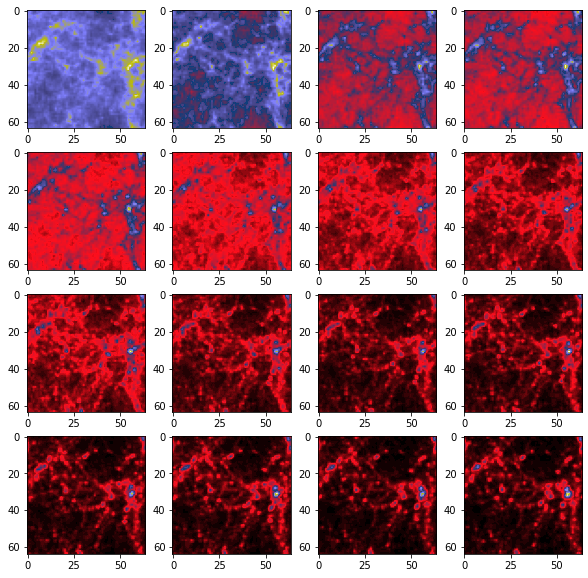

In [61]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [63]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

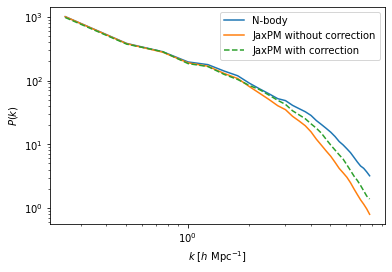

In [64]:
loglog(k, pk_ref, label='N-body')
loglog(k, pk_i, label='JaxPM without correction')
loglog(k, pk_c, '--', label='JaxPM with correction')
legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [ ]:
pk_c[-5:]

DeviceArray([1.9937136, 1.5983605, 1.3301713, 1.076778 , 0.8571578], dtype=float32)

In [ ]:
pk_ref[-5:]

DeviceArray([5.271436 , 4.565606 , 4.1961513, 3.6873434, 3.2047715], dtype=float32)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/hom

(0.0, 1.5)

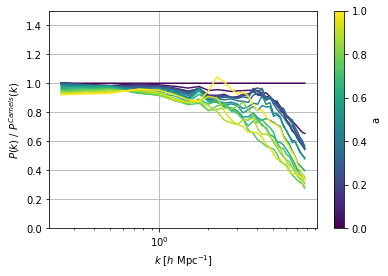

In [ ]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_c = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), res[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_c/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$ P(k) \ / \ P^{Camels}(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)
#plt.savefig('../figures/camels_residuals_pk_pos2.png',dpi=150)

/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/home/lamsade/gchatziloizos/miniconda3/envs/GeoSpace/lib/python3.9/site-packages/jax/_src/lax/lax.py:487: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)
/hom

(0.0, 1.5)

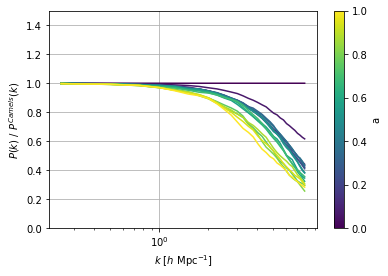

In [ ]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_i = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    semilogx(k, pk_i/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$ P(k) \ / \ P^{Camels}(k)$")
plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)
#plt.savefig('../figures/camels_residuals_nocorrection2.png',dpi=150)

In [ ]:
# import pickle
# pickle.dump( params, open( "Spectral_CV0.params", "wb" ) )

In [ ]:
paramsLoad

{'Layer': {'Layerw1': array([[[[[ 4.2806756e-02,  9.1015184e-03, -3.5161823e-02, ...,
              7.1551365e-01, -3.7485199e+00,  1.7660686e+00],
            [ 1.5144232e-03,  8.9956976e-02, -4.1207170e+00, ...,
              2.2473989e+00, -4.4309404e-01,  3.1332841e+00],
            [ 1.0036575e-01, -1.6502991e-01,  1.0984810e-01, ...,
             -4.5355554e+00,  1.8456210e+00,  1.4102476e+00],
            ...,
            [ 3.3934832e+00,  1.1967415e+00,  8.9157867e+00, ...,
              3.1602700e+00,  4.1149292e+00,  9.2862749e+00],
            [ 2.2403221e+00,  1.4625101e+00,  1.7972852e+00, ...,
             -4.1353550e+00, -2.2256482e+00,  3.1400323e+00],
            [ 2.9330144e+00, -1.9760456e+00, -8.4541219e-01, ...,
              6.5421599e-01,  1.6533920e+00, -9.8780411e-01]],
  
           [[ 1.8203340e-02, -5.8393106e-03,  8.6294807e-02, ...,
              8.9002638e+00,  5.4674644e+00,  1.6495098e+00],
            [-5.7444628e-03,  1.2332829e-02, -1.1984168e+00, ..